In [1]:
import os
import pandas as pd

folder_path = "StockData"
new_columns = ["Date", "Close", "High", "Low", "Open", "Volume"]

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)

        df = pd.read_csv(file_path, skiprows=3, header=None)
        df.columns = new_columns

        df.reset_index(drop=True, inplace=True)

        df.to_csv(file_path, index=False)

        print(f"Processed: {filename}")



Processed: ASIANPAINT.csv
Processed: AXISBANK.csv
Processed: BAJFINANCE.csv
Processed: COALINDIA.csv
Processed: HCLTECH.csv
Processed: HDFCBANK.csv
Processed: HINDUNILVR.csv
Processed: ICICIBANK.csv
Processed: INFY.csv
Processed: ITC.csv
Processed: JSWSTEEL.csv
Processed: KOTAKBANK.csv
Processed: LT.csv
Processed: MARUTI.csv
Processed: NESTLEIND.csv
Processed: ONGC.csv
Processed: POWERGRID.csv
Processed: RELIANCE.csv
Processed: SBIN.csv
Processed: SUNPHARMA.csv
Processed: TCS.csv
Processed: TECHM.csv
Processed: TITAN.csv
Processed: ULTRACEMCO.csv
Processed: WIPRO.csv


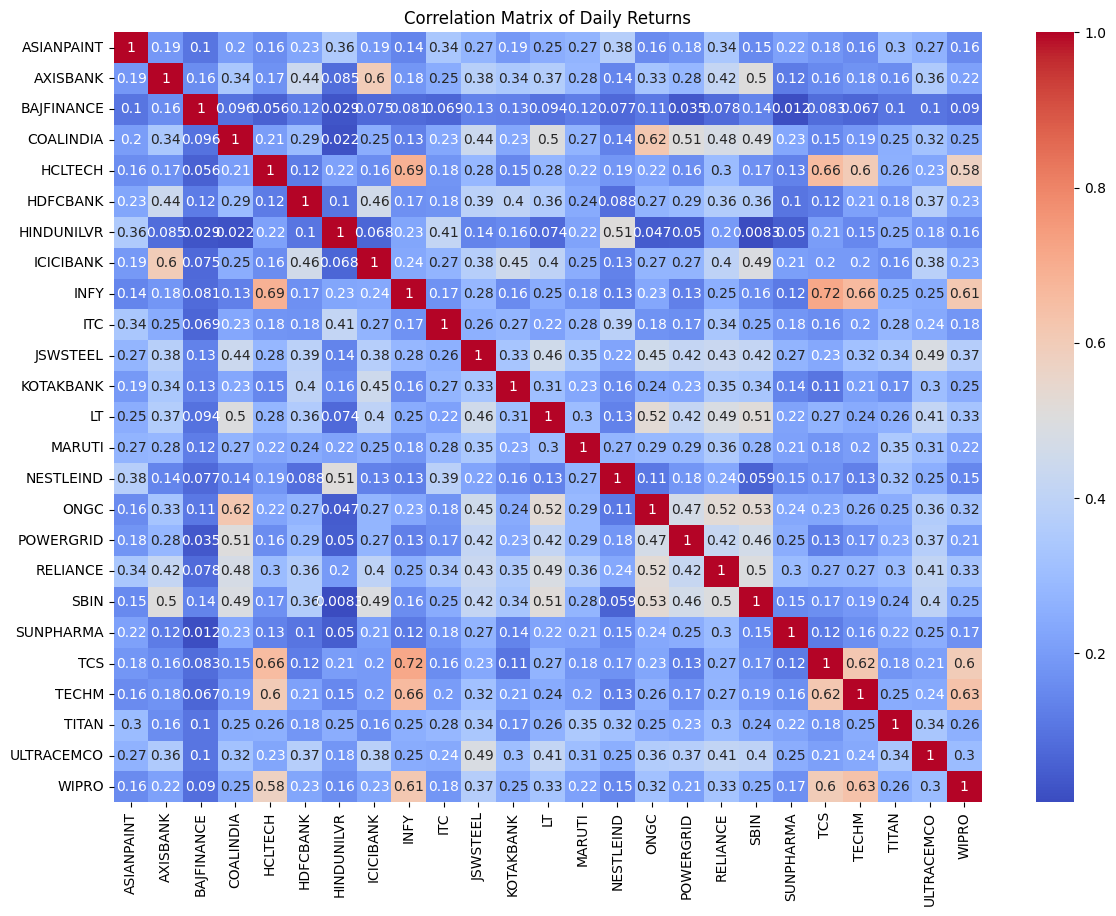

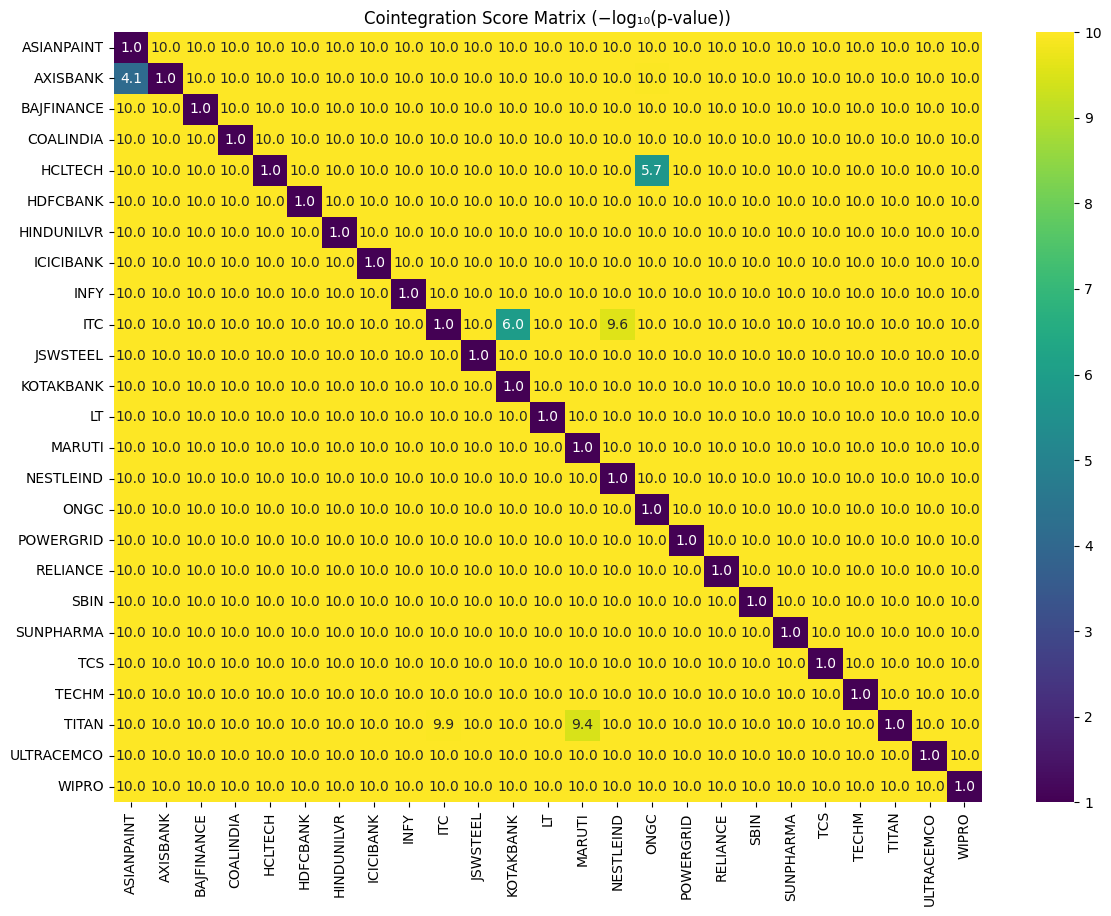

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

folder_path = "StockData"

returns_data = {}


for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        symbol = filename.replace(".csv", "")
        file_path = os.path.join(folder_path, filename)

        df = pd.read_csv(file_path, parse_dates=["Date"])
        df.sort_values("Date", inplace=True)

        # Compute daily returns
        df["Return"] = df["Close"].pct_change()

        returns_data[symbol] = df.set_index("Date")["Return"]

returns_df = pd.concat(returns_data.values(), axis=1)
returns_df.columns = returns_data.keys()
returns_df.dropna(inplace=True)

# ---------------------------------------
# Correlation Matrix Plot
# ---------------------------------------
plt.figure(figsize=(14, 10))
sns.heatmap(returns_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Daily Returns")
plt.show()

# ---------------------------------------
# Cointegration Matrix Plot
# ---------------------------------------

def compute_cointegration_matrix(df):
    n = df.shape[1]
    score_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i == j:
                score_matrix[i, j] = 1  # Perfect coint with self
            else:
                score, pval, _ = coint(df.iloc[:, i], df.iloc[:, j])
                score_matrix[i, j] = -np.log10(pval + 1e-10)  # Smaller pval → higher score

    return score_matrix

coint_matrix = compute_cointegration_matrix(returns_df)

plt.figure(figsize=(14, 10))
sns.heatmap(coint_matrix, xticklabels=returns_df.columns, yticklabels=returns_df.columns,
            annot=True, fmt=".1f", cmap='viridis')
plt.title("Cointegration Score Matrix (−log₁₀(p-value))")
plt.show()


In [3]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

# Load cleaned CSVs
infy = pd.read_csv("StockData/INFY.csv", parse_dates=["Date"])
tcs = pd.read_csv("StockData/TCS.csv", parse_dates=["Date"])

# Sort and align
infy = infy[["Date", "Close"]].rename(columns={"Close": "INFY"}).set_index("Date")
tcs = tcs[["Date", "Close"]].rename(columns={"Close": "TCS"}).set_index("Date")

# Merge on Date
df = infy.join(tcs, how="inner").dropna()


In [4]:
# Linear regression: INFY = alpha + beta * TCS
model = sm.OLS(df["INFY"], sm.add_constant(df["TCS"]))
result = model.fit()
beta = result.params["TCS"]

print(f"Hedge ratio (beta): {beta:.3f}")


Hedge ratio (beta): 0.504


In [5]:
# Spread = INFY - beta * TCS
df["Spread"] = df["INFY"] - beta * df["TCS"]

# Z-score of the spread
mean_spread = df["Spread"].mean()
std_spread = df["Spread"].std()
df["Z-Score"] = (df["Spread"] - mean_spread) / std_spread


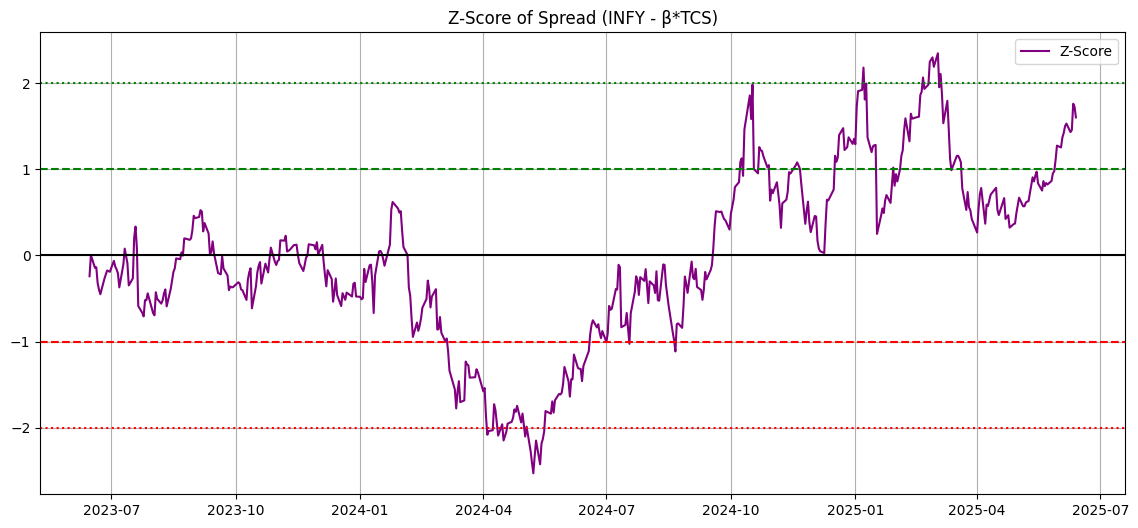

In [6]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["Z-Score"], label="Z-Score", color='purple')
plt.axhline(0, color='black')
plt.axhline(1, color='green', linestyle='--')
plt.axhline(-1, color='red', linestyle='--')
plt.axhline(2, color='green', linestyle=':')
plt.axhline(-2, color='red', linestyle=':')
plt.title("Z-Score of Spread (INFY - β*TCS)")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# === Load Preprocessed Data ===
infy = pd.read_csv("StockData/INFY.csv", parse_dates=["Date"])
tcs = pd.read_csv("StockData/TCS.csv", parse_dates=["Date"])

# === Keep Only Necessary Columns ===
infy = infy[["Date", "Open", "Close"]].rename(columns={"Open": "INFY_Open", "Close": "INFY_Close"}).set_index("Date")
tcs = tcs[["Date", "Open", "Close"]].rename(columns={"Open": "TCS_Open", "Close": "TCS_Close"}).set_index("Date")

# === Merge on Dates ===
df = infy.join(tcs, how="inner").dropna()

# === Hedge Ratio via OLS ===
X = sm.add_constant(df["TCS_Close"])
model = sm.OLS(df["INFY_Close"], X).fit()
beta = model.params["TCS_Close"]

# === Spread and Z-score ===
df["Spread"] = df["INFY_Close"] - beta * df["TCS_Close"]
df["ZScore"] = (df["Spread"] - df["Spread"].mean()) / df["Spread"].std()

# === Signal Logic ===
df["Signal"] = 0
df.loc[df["ZScore"] > 1, "Signal"] = -1   # SHORT Spread
df.loc[df["ZScore"] < -1, "Signal"] = 1   # LONG Spread
df.loc[df["ZScore"].between(-0.5, 0.5), "Signal"] = 0  # Exit Zone

# === Backtesting ===
trades = []
position = 0
entry = {}

for i in range(1, len(df) - 1):
    today = df.iloc[i]
    tomorrow = df.iloc[i + 1]

    if position == 0 and today["Signal"] != 0:
        # Entry
        entry = {
            "EntryDate": tomorrow.name,
            "Direction": "Long" if today["Signal"] == 1 else "Short",
            "Signal": today["Signal"],
            "INFY_Entry": tomorrow["INFY_Open"],
            "TCS_Entry": tomorrow["TCS_Open"]
        }
        position = today["Signal"]

    elif position != 0 and today["Signal"] == 0:
        # Exit
        entry["ExitDate"] = tomorrow.name
        entry["INFY_Exit"] = tomorrow["INFY_Open"]
        entry["TCS_Exit"] = tomorrow["TCS_Open"]

        # PnL calculation
        infy_pnl = (entry["INFY_Exit"] - entry["INFY_Entry"]) * position
        tcs_pnl = -beta * (entry["TCS_Exit"] - entry["TCS_Entry"]) * position
        entry["PnL"] = infy_pnl + tcs_pnl

        entry["HoldingDays"] = (entry["ExitDate"] - entry["EntryDate"]).days
        trades.append(entry)
        position = 0

# === Results ===
trades_df = pd.DataFrame(trades)
print(trades_df[["EntryDate", "ExitDate", "Direction", "PnL", "HoldingDays"]])
print("\nTotal PnL:", trades_df["PnL"].sum())
print("Total Trades:", len(trades_df))


    EntryDate   ExitDate Direction        PnL  HoldingDays
0  2024-03-05 2024-03-06      Long   2.764986            1
1  2024-03-07 2024-06-20      Long  28.334143          105
2  2024-07-02 2024-07-03      Long  15.160199            1
3  2024-07-19 2024-07-22      Long -34.195194            3
4  2024-08-22 2024-08-23      Long  23.777792            1
5  2024-10-09 2024-10-11     Short -23.706474            2
6  2024-10-14 2024-10-22     Short  40.668774            8
7  2024-10-23 2024-10-31     Short  70.687220            8
8  2024-11-19 2024-11-25     Short  38.657331            6
9  2024-12-18 2025-01-20     Short  92.772311           33
10 2025-01-30 2025-01-31     Short   7.165922            1
11 2025-02-05 2025-03-17     Short  25.621303           40
12 2025-03-18 2025-03-24     Short  43.316728            6

Total PnL: 331.02504163429126
Total Trades: 13


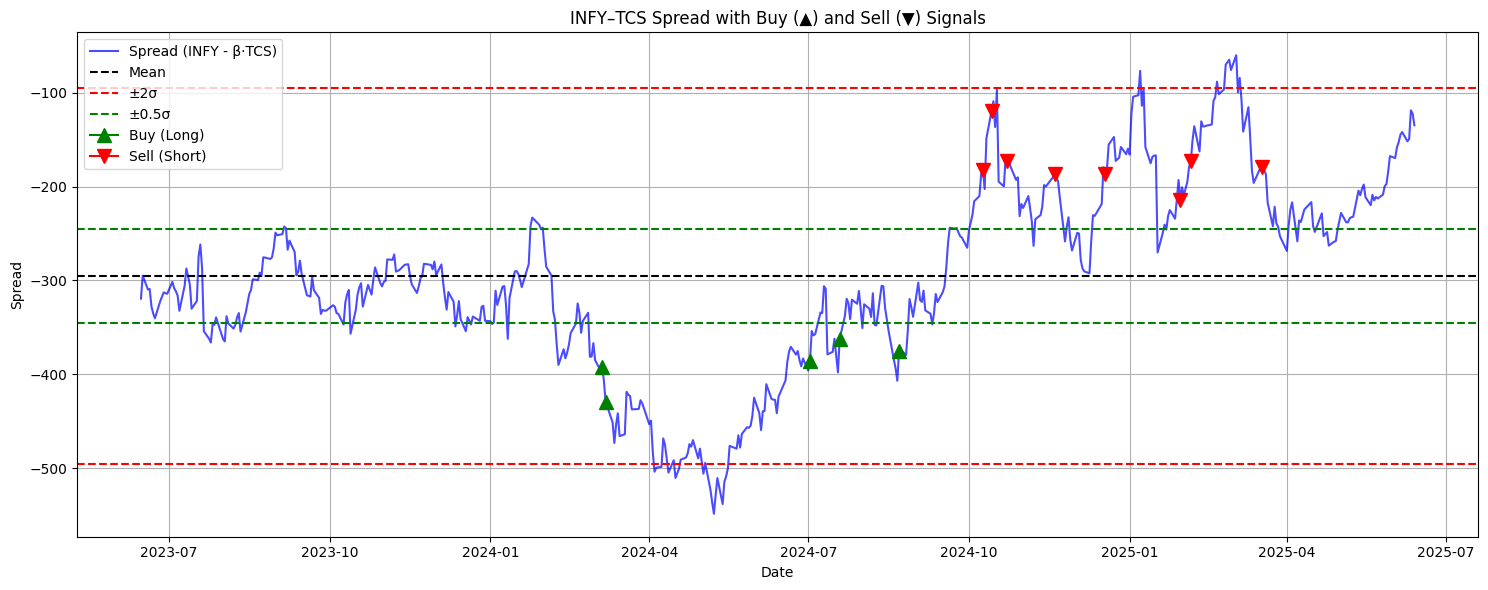

In [13]:
import matplotlib.pyplot as plt

# Prepare figure
plt.figure(figsize=(15, 6))
plt.plot(df.index, df["Spread"], label="Spread (INFY - β·TCS)", color="blue", alpha=0.7)

# Mean & Threshold Lines
mean = df["Spread"].mean()
std = df["Spread"].std()
plt.axhline(mean, color="black", linestyle="--", label="Mean")
plt.axhline(mean + 2 * std, color="red", linestyle="--", label="±2σ")
plt.axhline(mean - 2 * std, color="red", linestyle="--")
plt.axhline(mean + 0.5 * std, color="green", linestyle="--", label="±0.5σ")
plt.axhline(mean - 0.5 * std, color="green", linestyle="--")

# Add triangle markers
for _, row in trades_df.iterrows():
    entry_date = row["EntryDate"]
    entry_idx = df.index.get_loc(pd.to_datetime(entry_date))
    spread_val = df.iloc[entry_idx]["Spread"]
    
    if row["Direction"] == "Long":
        plt.plot(entry_date, spread_val, marker="^", color="green", markersize=10, label="Buy (Long)" if "Buy (Long)" not in plt.gca().get_legend_handles_labels()[1] else "")
    else:
        plt.plot(entry_date, spread_val, marker="v", color="red", markersize=10, label="Sell (Short)" if "Sell (Short)" not in plt.gca().get_legend_handles_labels()[1] else "")

plt.title("INFY–TCS Spread with Buy (▲) and Sell (▼) Signals")
plt.xlabel("Date")
plt.ylabel("Spread")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
import yfinance as yf
import pandas as pd

# Set ticker symbols for NSE
tickers = {"INFY": "INFY.NS", "TCS": "TCS.NS"}

# Define intervals and limits (yfinance restrictions)
intervals = {
    "1m": "7d",    # Max 7 days for 1m data
    "5m": "30d",   # Max 30 days
    "10m": "30d",
    "30m": "60d",
    "60m": "60d",
    "180m": "60d"  # 3hr = 180m
}

# Download and save each
for name, symbol in tickers.items():
    for interval, period in intervals.items():
        try:
            df = yf.download(symbol, interval=interval, period=period, progress=False)
            if not df.empty:
                df.reset_index(inplace=True)
                df.to_csv(f"{name}_{interval}.csv", index=False)
                print(f"Saved {name}_{interval}.csv")
            else:
                print(f"No data for {name} at {interval}")
        except Exception as e:
            print(f"Error downloading {name} {interval}: {e}")


YF.download() has changed argument auto_adjust default to True
Saved INFY_1m.csv
Saved INFY_5m.csv



1 Failed download:
['INFY.NS']: YFPricesMissingError('possibly delisted; no price data found  (period=30d) (Yahoo error = "Invalid input - interval=10m is not supported. Valid intervals: , 2m, 5m, 15m, 30m, 60m, 90m, 1h, 4h, 1d, 5d, 1wk, 1mo, 3mo]")')


No data for INFY at 10m
Saved INFY_30m.csv
Saved INFY_60m.csv



1 Failed download:
['INFY.NS']: YFPricesMissingError('possibly delisted; no price data found  (period=60d) (Yahoo error = "Invalid input - interval=180m is not supported. Valid intervals: , 2m, 5m, 15m, 30m, 60m, 90m, 1h, 4h, 1d, 5d, 1wk, 1mo, 3mo]")')


No data for INFY at 180m
Saved TCS_1m.csv
Saved TCS_5m.csv



1 Failed download:
['TCS.NS']: YFPricesMissingError('possibly delisted; no price data found  (period=30d) (Yahoo error = "Invalid input - interval=10m is not supported. Valid intervals: , 2m, 5m, 15m, 30m, 60m, 90m, 1h, 4h, 1d, 5d, 1wk, 1mo, 3mo]")')


No data for TCS at 10m
Saved TCS_30m.csv
Saved TCS_60m.csv



1 Failed download:
['TCS.NS']: YFPricesMissingError('possibly delisted; no price data found  (period=60d) (Yahoo error = "Invalid input - interval=180m is not supported. Valid intervals: , 2m, 5m, 15m, 30m, 60m, 90m, 1h, 4h, 1d, 5d, 1wk, 1mo, 3mo]")')


No data for TCS at 180m


In [18]:
import os
import pandas as pd

# List of your 8 files
files = [
    "INFY_1m.csv", "INFY_5m.csv", "INFY_30m.csv", "INFY_60m.csv",
    "TCS_1m.csv", "TCS_5m.csv", "TCS_30m.csv", "TCS_60m.csv"
]

# Correct column names
new_columns = ["Date", "Close", "High", "Low", "Open", "Volume"]

# Clean and overwrite
for file in files:
    if os.path.exists(file):
        df = pd.read_csv(file, skiprows=3, header=None)

        if df.shape[1] >= len(new_columns):
            df = df.iloc[:, :len(new_columns)]
            df.columns = new_columns
            df.to_csv(file, index=False)
            


In [19]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

def load_data(interval="1m"):
    infy = pd.read_csv(f"INFY_{interval}.csv", parse_dates=["Date"])
    tcs = pd.read_csv(f"TCS_{interval}.csv", parse_dates=["Date"])

    infy = infy[["Date", "Close"]].rename(columns={"Close": "INFY"})
    tcs = tcs[["Date", "Close"]].rename(columns={"Close": "TCS"})

    df = pd.merge(infy, tcs, on="Date").set_index("Date")
    df.dropna(inplace=True)
    return df

def correlation_cointegration(df):
    corr = df["INFY"].pct_change().corr(df["TCS"].pct_change())
    score, pvalue, _ = coint(df["INFY"], df["TCS"])
    print(f"📈 Correlation: {corr:.4f}")
    print(f"📉 Cointegration p-value: {pvalue:.4f}")
    return corr, pvalue

def compute_spread_zscore(df):
    X = sm.add_constant(df["TCS"])
    model = sm.OLS(df["INFY"], X).fit()
    hedge_ratio = model.params["TCS"]
    df["Spread"] = df["INFY"] - hedge_ratio * df["TCS"]
    df["ZScore"] = (df["Spread"] - df["Spread"].rolling(100).mean()) / df["Spread"].rolling(100).std()
    return df, hedge_ratio

def backtest(df, entry_z=2.0, exit_z=0.5):
    trades = []
    position = None

    for i in range(1, len(df)):
        z = df["ZScore"].iloc[i]
        prev_z = df["ZScore"].iloc[i-1]
        time = df.index[i]
        infy_price = df["INFY"].iloc[i]
        tcs_price = df["TCS"].iloc[i]

        if position is None:
            if z > entry_z:
                position = {"type": "ShortSpread", "entry_time": time,
                            "INFY_entry": infy_price, "TCS_entry": tcs_price}
            elif z < -entry_z:
                position = {"type": "LongSpread", "entry_time": time,
                            "INFY_entry": infy_price, "TCS_entry": tcs_price}

        elif position:
            if (position["type"] == "ShortSpread" and z < exit_z) or \
               (position["type"] == "LongSpread" and z > -exit_z):
                position["exit_time"] = time
                position["INFY_exit"] = infy_price
                position["TCS_exit"] = tcs_price
                trades.append(position)
                position = None

    return pd.DataFrame(trades)

def run_strategy(interval):
    print(f"\n=== Running Pair Strategy on {interval} Data ===")
    df = load_data(interval)
    correlation_cointegration(df)
    df, hedge = compute_spread_zscore(df)
    trades = backtest(df)
    print(f"Total Trades: {len(trades)}")
    print(trades.head())
    
    # Plot spread + signals
    plt.figure(figsize=(15, 6))
    plt.plot(df.index, df["Spread"], label="Spread", alpha=0.7)
    plt.axhline(0, color="black", linestyle="--")
    plt.axhline(2*df["Spread"].std(), color="red", linestyle="--", label="±2σ")
    plt.axhline(-2*df["Spread"].std(), color="red", linestyle="--")
    for _, row in trades.iterrows():
        plt.axvline(row["entry_time"], color="green" if row["type"] == "LongSpread" else "red", linestyle="--", alpha=0.4)
    plt.title(f"{interval} Spread | Hedge Ratio: {hedge:.2f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



=== Running Pair Strategy on 1m Data ===
📈 Correlation: 0.6232
📉 Cointegration p-value: 0.4739
Total Trades: 34
          type                entry_time   INFY_entry    TCS_entry  \
0  ShortSpread 2025-06-05 06:37:00+00:00  1560.800049  3397.100098   
1  ShortSpread 2025-06-05 09:40:00+00:00  1552.599976  3366.000000   
2   LongSpread 2025-06-06 04:16:00+00:00  1545.199951  3361.800049   
3  ShortSpread 2025-06-06 05:56:00+00:00  1555.000000  3378.399902   
4   LongSpread 2025-06-06 08:07:00+00:00  1556.199951  3380.000000   

                  exit_time    INFY_exit     TCS_exit  
0 2025-06-05 08:24:00+00:00  1552.599976  3370.500000  
1 2025-06-05 09:52:00+00:00  1556.800049  3376.199951  
2 2025-06-06 05:35:00+00:00  1554.000000  3383.300049  
3 2025-06-06 06:54:00+00:00  1557.400024  3380.500000  
4 2025-06-06 08:13:00+00:00  1555.699951  3376.199951  


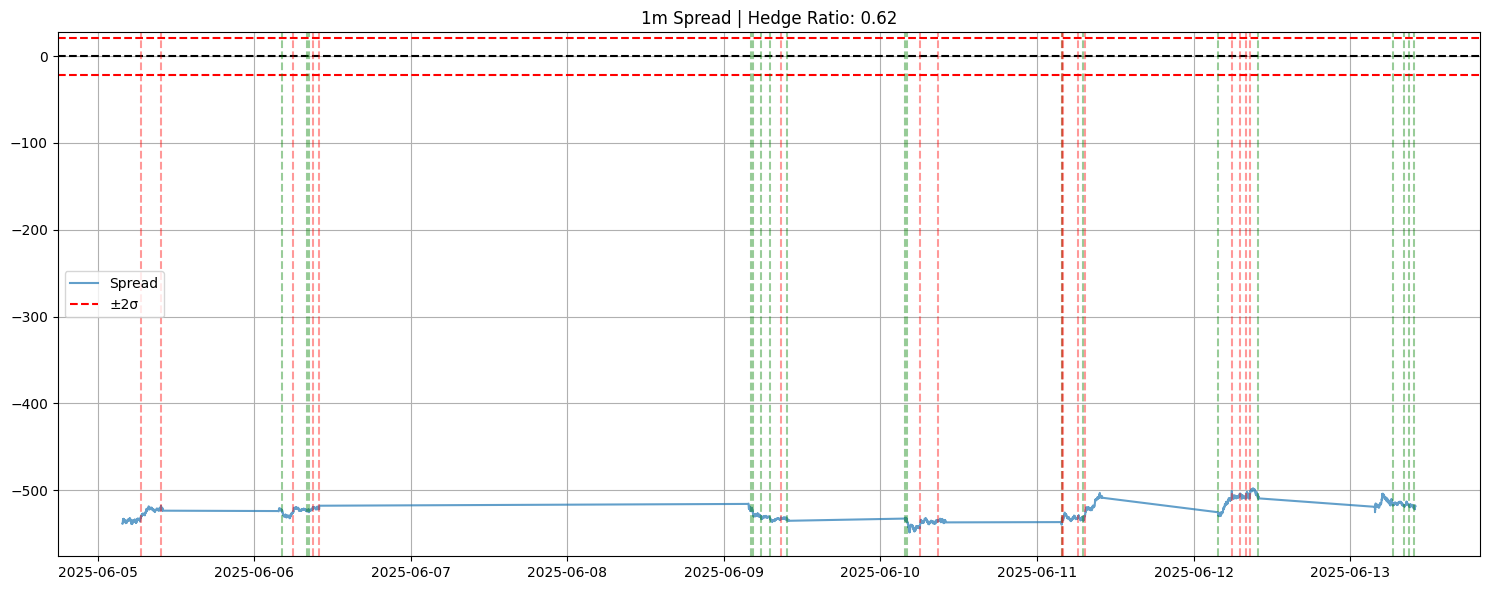

In [20]:
run_strategy("1m")


=== Running Pair Strategy on 5m Data ===
📈 Correlation: 0.7216
📉 Cointegration p-value: 0.6966
Total Trades: 26
          type                entry_time   INFY_entry    TCS_entry  \
0  ShortSpread 2025-05-06 06:15:00+00:00  1512.000000  3453.000000   
1  ShortSpread 2025-05-07 05:00:00+00:00  1509.300049  3438.600098   
2  ShortSpread 2025-05-07 06:45:00+00:00  1509.699951  3438.500000   
3   LongSpread 2025-05-08 04:00:00+00:00  1507.800049  3470.000000   
4  ShortSpread 2025-05-09 06:50:00+00:00  1506.599976  3420.199951   

                  exit_time    INFY_exit     TCS_exit  
0 2025-05-06 07:25:00+00:00  1510.099976  3461.800049  
1 2025-05-07 05:55:00+00:00  1507.099976  3446.199951  
2 2025-05-07 09:10:00+00:00  1511.300049  3452.000000  
3 2025-05-08 05:50:00+00:00  1508.500000  3445.100098  
4 2025-05-09 08:55:00+00:00  1505.400024  3430.000000  


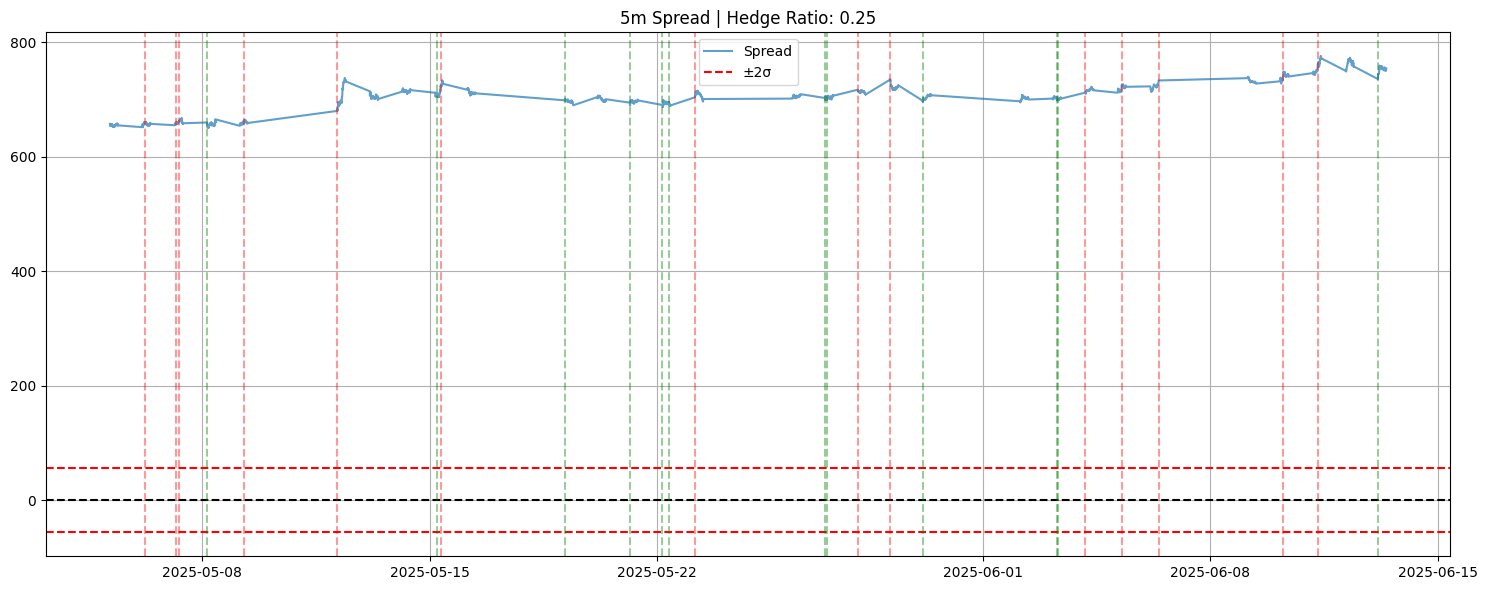

In [21]:
run_strategy('5m')


=== Running Pair Strategy on 30m Data ===
📈 Correlation: 0.8154
📉 Cointegration p-value: 0.7923
Total Trades: 6
          type                entry_time   INFY_entry    TCS_entry  \
0  ShortSpread 2025-04-04 05:30:00+00:00  1457.000000  3313.300049   
1  ShortSpread 2025-05-02 08:00:00+00:00  1510.900024  3439.100098   
2  ShortSpread 2025-05-12 07:30:00+00:00  1608.900024  3598.199951   
3  ShortSpread 2025-05-23 06:00:00+00:00  1577.000000  3506.199951   
4  ShortSpread 2025-05-28 04:00:00+00:00  1577.500000  3503.600098   

                  exit_time    INFY_exit     TCS_exit  
0 2025-04-07 08:00:00+00:00  1379.699951  3208.050049  
1 2025-05-05 04:00:00+00:00  1517.099976  3497.399902  
2 2025-05-16 08:30:00+00:00  1586.800049  3558.100098  
3 2025-05-23 08:00:00+00:00  1573.199951  3518.600098  
4 2025-05-30 04:00:00+00:00  1563.000000  3492.199951  


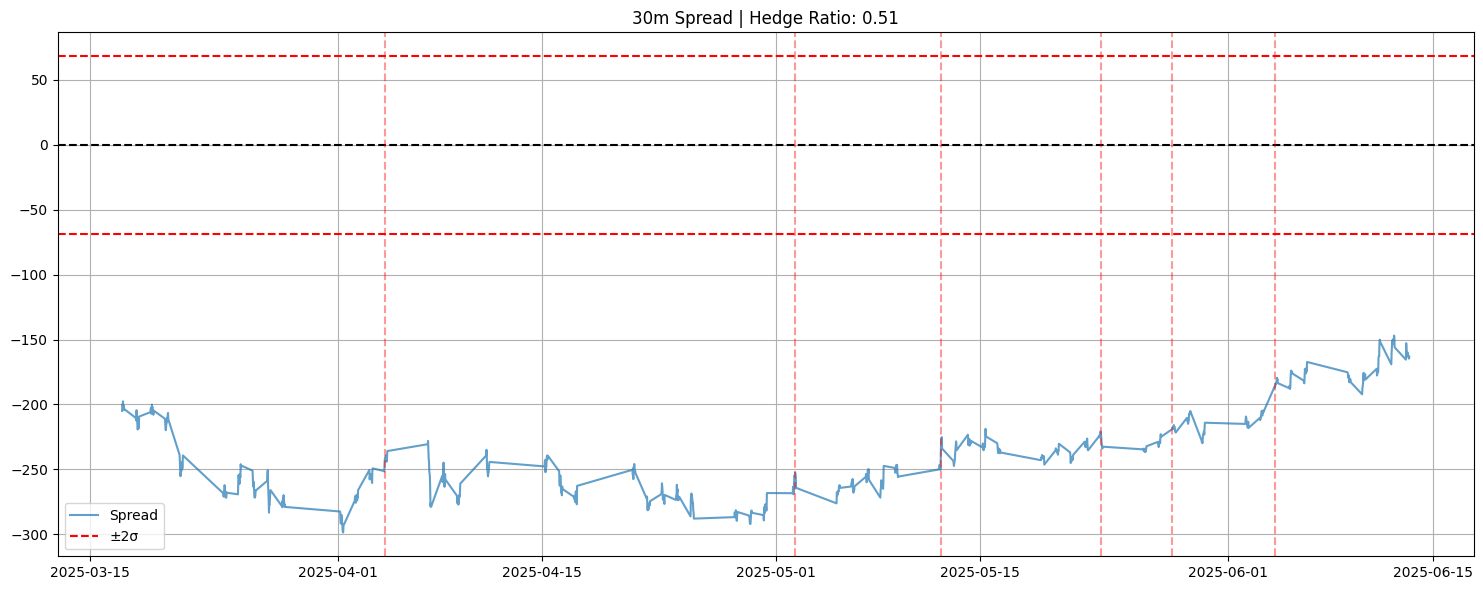

In [22]:
run_strategy('30m')


=== Running Pair Strategy on 60m Data ===
📈 Correlation: 0.8200
📉 Cointegration p-value: 0.8053
Total Trades: 3
          type                entry_time   INFY_entry    TCS_entry  \
0   LongSpread 2025-04-25 08:45:00+00:00  1480.900024  3451.899902   
1  ShortSpread 2025-05-12 06:45:00+00:00  1608.000000  3602.100098   
2  ShortSpread 2025-05-28 05:45:00+00:00  1578.300049  3497.000000   

                  exit_time    INFY_exit     TCS_exit  
0 2025-04-30 08:45:00+00:00  1500.300049  3449.800049  
1 2025-05-19 09:45:00+00:00  1557.900024  3518.800049  
2 2025-05-30 03:45:00+00:00  1561.099976  3488.899902  


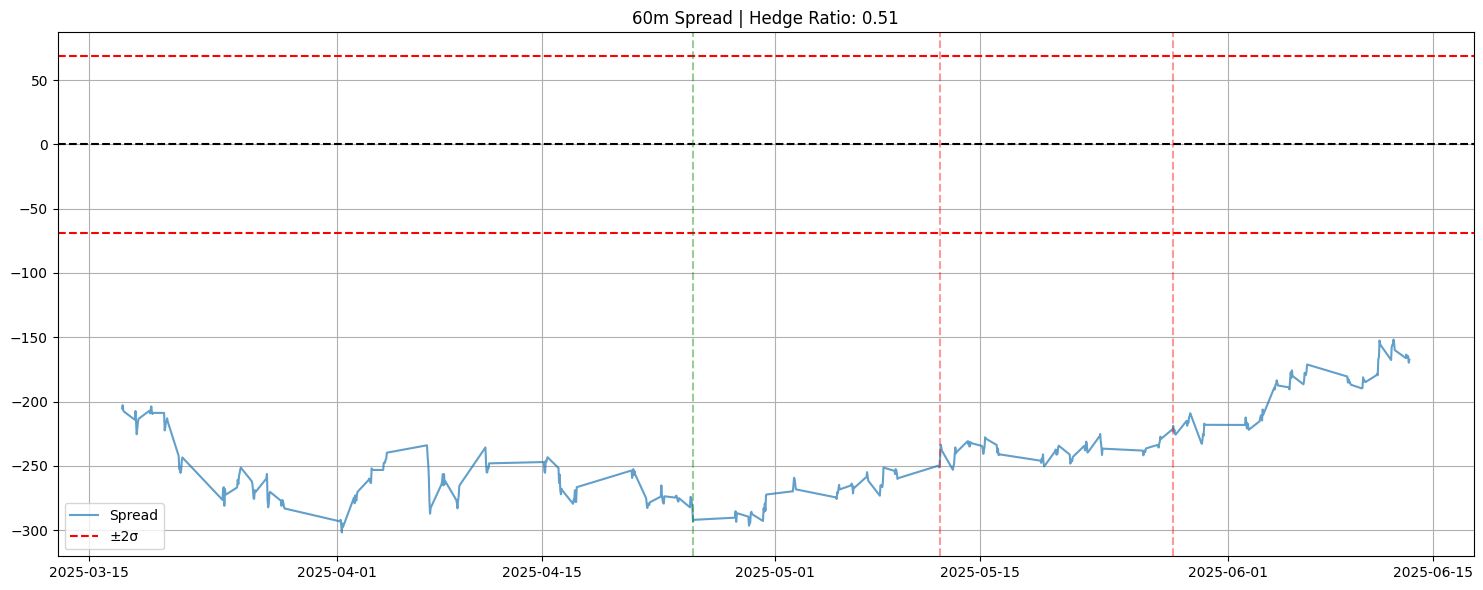

In [23]:
run_strategy('60m')